In [1]:
%pip install jupyter 
%pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U langgraph langsmith
%pip install -U "langchain[openai]"
%pip install -U langchain-tavily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

from dotenv import load_dotenv

from typing import Annotated, List

from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import ToolMessage
from langgraph.checkpoint.memory import MemorySaver

from pydantic import BaseModel, Field

In [4]:
# Example of supporting parsing of annotations, nested schemas, and other features:
# @tool
# def multiply(a: int, b: int) -> int: # can be made async
#     """Multiply two numbers."""
#     return a * b

# @tool
# def multiply_by_max(
#     a: Annotated[int, "scale factor"],
#     b: Annotated[List[int], "list of ints over which to take maximum"],
# ) -> int:
#     """Multiply a by the maximum of b."""
#     return a * max(b)

#This is what it looks like in json
# {
#     'description': 'Multiply a by the maximum of b.',
#         'properties': {
#             'a': {
#                 'description': 'scale factor',
#                 'title': 'A',
#                 'type': 'integer'
#             },
#             'b': {
#                 'description': 'list of ints over which to take maximum',
#                 'items': {'type': 'integer'},
#                 'title': 'B',
#                 'type': 'array'
#             }
#         },
#     'required': ['a', 'b'],
#     'title': 'multiply_by_maxSchema',
#     'type': 'object'
# }



# class CalculatorInput(BaseModel): 
#     a: int = Field(description="first number")
#     b: int = Field(description="second number")

# # Name = multiplication-tool
# # description = Multiply two numbers
# @tool("multiplication-tool", args_schema=CalculatorInput, return_direct=True)
# def multiply(a: int, b: int) -> int:
#     """Multiply two numbers."""
#     return a * b


In [5]:
# Test MANY tools for property management tasks
@tool
def get_property_status() -> str:
    """Used to check the current status or condition of a property. Handles questions like:
    'Has work started?', 'Is the property secure?', 'Did the bid get approved?', or
    'What is the latest inspection result?'"""
    return "get_property_status"

@tool
def get_occupancy_status() -> str:
    """Used to determine if a property is occupied or vacant. Handles questions like:
    'Is the property vacant or occupied?' or 'When was the last confirmed vacancy inspection?'"""
    return "get_occupancy_status"

@tool
def get_hazard_summary() -> str:
    """Used to retrieve any known hazard or storm damage. Handles queries such as:
    'Was there storm damage reported?', 'Is there mold or water damage?', or 
    'Is this damage claimable?'"""
    return "get_hazard_summary"

@tool
def get_bid_status() -> str:
    """Used to determine the status of a submitted bid. Handles questions like:
    'Has the bid been submitted to HUD?', 'Was it denied or accepted?', or 
    'Can I see the investor notes?'"""
    return "get_bid_status"

@tool
def get_work_order_progress() -> str:
    """Used to check progress of work orders. Handles questions such as:
    'Did the contractor complete the work?', 'Is it ready for audit?', or
    'When is the final debris pickup scheduled?'"""
    return "get_work_order_progress"

@tool
def get_cost_breakdown() -> str:
    """Used to provide cost details for specific repairs. Handles questions like:
    'What's the price for mold remediation?' or 'Is this cost within HUD guidelines?'"""
    return "get_cost_breakdown"

@tool
def get_insurance_claim_support() -> str:
    """Used to assist with insurance claims. Answers questions such as:
    'Do you have photos for a claim?', 'Was the damage flagged for insurance?',
    or 'Is the claim pending due to missing documents?'"""
    return "get_insurance_claim_support"

@tool
def get_vacancy_documentation() -> str:
    """Used to retrieve vacancy or insurable event records. Handles questions like:
    'Do you have proof of vacancy before the damage?' or 
    'What date was the loss discovered and reported?'"""
    return "get_vacancy_documentation"

@tool
def get_conveyance_readiness() -> str:
    """Used to check if a property is ready for conveyance. Handles queries like:
    'Can this property be conveyed?', 'Why is it not conveyable?', or
    'When will the make-ready work be complete?'"""
    return "get_conveyance_readiness"

@tool
def get_deadline_monitoring() -> str:
    """Used to check compliance with legal and investor deadlines. Handles:
    'Are we going to miss the first legal deadline?' or 
    'Is the 60-day conveyance deadline being met?'"""
    return "get_deadline_monitoring"

@tool
def get_invoice_status() -> str:
    """Used to check status of invoices and payments. Handles:
    'Was this work invoiced?', 'Has it been submitted to HUD?', or
    'Was it rejected or adjusted?'"""
    return "get_invoice_status"

@tool
def get_pricing_questions() -> str:
    """Used to answer pricing policy questions. Handles:
    'Why is reglazing billed at $2.00/UI?', 'Is boarding allowed on this window type?', or 
    'What’s the per cubic yard debris rate?'"""
    return "get_pricing_questions"

@tool
def get_audit_status() -> str:
    """Used to surface audit findings. Answers:
    'Was this property reviewed by QA?', 'Was the vendor penalized?', or
    'What’s the discrepancy in this photo set?'"""
    return "get_audit_status"

@tool
def get_vendor_escalation() -> str:
    """Used to escalate vendor performance issues. Handles:
    'Why did this vendor miss deadline?' or 'Can you reassign this zone?'"""
    return "get_vendor_escalation"

@tool
def get_case_notes() -> str:
    """Used to retrieve internal communication logs or updates. Handles:
    'When was the last update?' or 'Did anyone call the homeowner?'"""
    return "get_case_notes"

@tool
def get_documents() -> str:
    """Used to retrieve or send files. Handles:
    'Can I get the before/after photos?' or 'I need the PDF of the bid.'"""
    return "get_documents"

@tool
def log_escalation() -> str:
    """Used to formally log an escalation. Handles:
    'I need a supervisor.' or 'This has been delayed 3x—escalate.'"""
    return "log_escalation"

@tool
def reassign_work() -> str:
    """Used to reassign a task or zone to another vendor. Handles:
    'This vendor isn’t responsive. Can you reassign?'"""
    return "reassign_work"

@tool
def log_change_request() -> str:
    """Used to add or modify work scopes. Handles:
    'Can you add mold testing?' or 'Remove the garage from the bid.'"""
    return "log_change_request"

@tool
def advanced_summarize_delays() -> str:
    """Used to summarize all delays or blockers on an asset."""
    return "advanced_summarize_delays"

@tool
def advanced_risk_compliance() -> str:
    """Used to find assets at risk of missing compliance deadlines."""
    return "advanced_risk_compliance"

@tool
def advanced_rejected_bids() -> str:
    """Used to identify rejected bids, especially those rejected due to photo issues."""
    return "advanced_rejected_bids"


In [6]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

if not api_key:
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please set it in your .env file.")

os.environ["OPENAI_API_KEY"] = api_key
llm = init_chat_model("openai:gpt-4.1")

# Collect all your tools and make tools visible to the LLM
# tools = [multiply]
tools = [
    get_property_status,
    get_occupancy_status,
    get_hazard_summary,
    get_bid_status,
    get_work_order_progress,
    get_cost_breakdown,
    get_insurance_claim_support,
    get_vacancy_documentation,
    get_conveyance_readiness,
    get_deadline_monitoring,
    get_invoice_status,
    get_pricing_questions,
    get_audit_status,
    get_vendor_escalation,
    get_case_notes,
    get_documents,
    log_escalation,
    reassign_work,
    log_change_request,
    advanced_summarize_delays,
    advanced_risk_compliance,
    advanced_rejected_bids,
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# NOT NEEDED ANYMORE SINCE USING tools_condition
# Function to determine next step based on the last message
# def route_tools(
#     state: State,
# ):
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.
#     """
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#         return "tools"
#     return END


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

# Create a tools node that will execute the tools
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node) 
# Tool_node docs if needed
# - https://docs.langchain.com/langgraph-platform/langgraph-basics/2-add-tools#5-create-a-function-to-run-the-tools 
# - https://langchain-ai.github.io/langgraph/reference/prebuilt/?_gl=1*1dwed7s*_gcl_au*NjcwMjkyMzE2LjE3NTQ0ODU2Njg.*_ga*NDUwMzM4NzY3LjE3NTQ0ODcwNTQ.*_ga_47WX3HKKY2*czE3NTQ0ODcwNTMkbzEkZzEkdDE3NTQ0OTM0MDUkajYwJGwwJGgw#toolnode

# Add edges
graph_builder.add_edge(START, "chatbot")

# Add conditional routing
graph_builder.add_conditional_edges(
    "chatbot", 
    tools_condition,
)

# NOT NEEDED ANYMORE SINCE USING tools_condition
# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
#     # It defaults to the identity function, but if you
#     # want to use a node named something else apart from "tools",
#     # You can update the value of the dictionary to something else
#     # e.g., "tools": "my_tools"
#     {"tools": "tools", END: END},
# )

# After calling tools, always go back to the chatbot
graph_builder.add_edge("tools", "chatbot")

# save memory after each chatbot node
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory) # creates a CompiledStateGraph we can invoke on our state

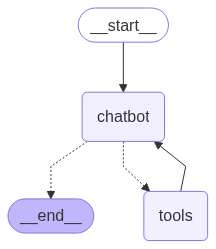

In [7]:
# DISPLAY GRAPH
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    tools_called = []
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        stream_mode="updates",  # <-- ensure updates is set!
        config=config,
    ):
        # event is a dict: {node_name: {"messages": [...]}}
        for node_name, value in event.items():
            # After tools node: could be multiple new ToolMessages in value["messages"]
            new_messages = value["messages"]
            for msg in new_messages:
                if hasattr(msg, 'name') and msg.name:
                    print(f"Tool ({msg.name}): {msg.content}")
                    tools_called.append(msg.content)
                elif hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"Assistant (calling tools): {msg.content}")
                else:
                    print(f"Assistant: {msg.content}")
        
    print("\n\n" + f'{tools_called}')


# generate random thread_id and set the config
# COVERSATIONS WITH THE SAME THREAD ID WILL HAVE THE SAME MEMORY
import random
random_thread_id = random.randint(1, 10000000)
config = { "configurable": {"thread_id": random_thread_id} }

print(config.get("configurable", {}).get("thread_id", "No thread ID set")) # Print the thread ID for debugging


# Uncomment to use in a conversation loop
# while True:
#     user_input = input("User: ")
#     if user_input.lower() in ["quit", "exit", "q"]:
#         print("Goodbye!")
#         break
#     stream_graph_updates(user_input)


# For testing purposes, you can set a user input directly or send just one message
# user_input = input("User: ")
user_input = "Was there water damage reported, is it claimable, and do we have proof the property was vacant before the loss?"
stream_graph_updates(user_input)

6433620
Assistant (calling tools): 
Tool (get_hazard_summary): get_hazard_summary
Tool (get_vacancy_documentation): get_vacancy_documentation
Assistant (calling tools): 
Tool (get_insurance_claim_support): get_insurance_claim_support
Assistant: I'm checking for water damage, whether it is claimable for insurance, and if we have proof the property was vacant before the loss. Please hold while I gather the details.


['get_hazard_summary', 'get_vacancy_documentation', 'get_insurance_claim_support']
